In [1]:
import pandas as pd
import numpy as np
import sys, os

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

### Data

In [2]:
df = pd.read_csv("data/filtered_tsla_options_w_greeks.csv")
df = df[df.date_current == '2020-07-13']

In [3]:
df.head()

,date_current,ticker,expiration_date,days_to_expiry,option_id,option_type,strike_price,bid_price,option_price,ask_price,...,vega,rho,vanna,vomma,charm,veta,speed,zomma,color,ultima
0,2020-07-13,TSLA,2020-08-21,39.0,TSLA 2020-08-21 C232,C,232.0,81.38,83.92,84.76,...,0.270787,0.168850,-0.001107,0.092721,0.001670,0.004870,-0.000026,-0.001219,-0.000018,-0.233596
1,2020-07-13,TSLA,2020-08-21,39.0,TSLA 2020-08-21 C234,C,234.0,79.70,126.27,83.30,...,0.275230,0.168816,-0.001093,0.089479,0.001638,0.004869,-0.000026,-0.001305,-0.000020,-0.230026
2,2020-07-13,TSLA,2020-08-21,39.0,TSLA 2020-08-21 C236,C,236.0,78.69,88.73,82.30,...,0.281300,0.167491,-0.001033,0.081835,0.001562,0.004845,-0.000026,-0.001384,-0.000021,-0.214270
3,2020-07-13,TSLA,2020-08-21,39.0,TSLA 2020-08-21 C238,C,238.0,77.10,89.68,80.72,...,0.285528,0.167463,-0.001018,0.078803,0.001528,0.004843,-0.000026,-0.001472,-0.000022,-0.210680
4,2020-07-13,TSLA,2020-08-21,39.0,TSLA 2020-08-21 C240,C,240.0,75.80,77.60,79.60,...,0.290668,0.166610,-0.000973,0.073149,0.001464,0.004827,-0.000026,-0.001552,-0.000023,-0.199588


### Get Expiration Pairs

In [4]:
expirations = df.expiration_date.unique()
days = df.days_to_expiry.unique()

expiration_pairs = []
for i in range(len(expirations)):
    
    for exp, day in zip(expirations[i:], days[i:]):
        
        if expirations[i] == exp:
            continue
            
        expiration_pairs.append([expirations[i], exp, days[i], day])

### Check Pairs

In [5]:
cols = [
    'strike_price',
    'delta',
    'vega',
    'theta',
    'gamma',
    'vomma',
    'ultima',
    'implied_volatility'
]

ocols = [
    'delta_x',
    'vega_x',
    'theta_x',
    'gamma_x',
    'vomma_x',
    'ultima_x',
    'iv_x',
    'delta_y',
    'vega_y',
    'theta_y',
    'gamma_y',
    'vomma_y',
    'ultima_y',
    'iv_y'
]

# TRADES = [1, -1, 1, -1]
TRADES = [-1, 1, -1, 1]

positions = []
for pair in expiration_pairs:
        
    e1, e2, day1, day2 = pair
    d1 = df[df.expiration_date == e1]
    d2 = df[df.expiration_date == e2]
    
    d1c = d1[d1.option_type == 'C'][cols]
    d1p = d1[d1.option_type == 'P'][cols]
    
    d2c = d2[d2.option_type == 'C'][cols]
    d2p = d2[d2.option_type == 'P'][cols]
    
    calls = d1c.merge(d2c, on='strike_price', how='inner')
    puts = d1p.merge(d2p, on='strike_price', how='inner')
        
    puts['moneyness'] = ((1 - puts.strike_price / 299.41) * 100).round(0)
    calls['moneyness'] = ((calls.strike_price / 299.41 - 1) * 100).round(0)
    
    puts['abs_moneyness'] = puts.moneyness.abs().reset_index(drop=True)
    calls['abs_moneyness'] = calls.moneyness.abs().reset_index(drop=True)
    
    puts = puts.drop_duplicates(subset=['moneyness'], keep='first')
    puts = puts.sort_values('moneyness')
    
    calls = calls.drop_duplicates(subset=['moneyness'], keep='first')
    calls = calls.sort_values('moneyness')
    
    puts = puts.drop(['abs_moneyness'], axis=1)
    calls = calls.drop(['abs_moneyness'], axis=1)
        
    puts.columns = ['strike_price'] + ['put_'+col for col in ocols] + ['moneyness']
    calls.columns = ['strike_price'] + ['call_'+col for col in ocols] + ['moneyness']
    
    legs = calls.merge(puts, on=['moneyness'], how='inner')
    
    pos = pd.DataFrame()
    
    for greek in ['Delta', 'Gamma', 'Theta', 'Vega', 'Vomma', 'Ultima']:
        
        value = TRADES[0] * legs['call_'+greek.lower()+'_x'].values
        value += TRADES[1] * legs['call_'+greek.lower()+'_y'].values
        value += TRADES[2] * legs['put_'+greek.lower()+'_x'].values
        value += TRADES[3] * legs['put_'+greek.lower()+'_y'].values
        
        pos['Net'+greek] = value
    
    
    pos['CallStrike'] = legs.strike_price_x
    pos['PutStrike'] = legs.strike_price_y
    
    pos['Date1'] = e1
    pos['Date2'] = e2
    
    pos['Days1'] = day1
    pos['Days2'] = day2
    
    positions.append(pos)
        
positions = pd.concat(positions)

In [6]:
legs[['call_vega_x', 'call_vega_y', 'put_vega_x', 'put_vega_y']]

,call_vega_x,call_vega_y,put_vega_x,put_vega_y


In [7]:
positions.sort_values("NetVega")

,NetDelta,NetGamma,NetTheta,NetVega,NetVomma,NetUltima,CallStrike,PutStrike,Date1,Date2,Days1,Days2
5,0.012638,-0.000219,0.050755,0.117408,-0.036740,-0.037361,310.0,286.0,2020-12-18,2021-01-15,158.0,186.0
2,0.012773,-0.000216,0.051013,0.117712,-0.036671,-0.037938,284.0,314.0,2020-12-18,2021-01-15,158.0,186.0
4,0.012595,-0.000215,0.051336,0.117727,-0.036678,-0.037186,308.0,290.0,2020-12-18,2021-01-15,158.0,186.0
1,0.012837,-0.000214,0.050739,0.117739,-0.036613,-0.039081,278.0,320.0,2020-12-18,2021-01-15,158.0,186.0
3,0.013017,-0.000218,0.051316,0.117803,-0.036861,-0.036784,300.0,300.0,2020-12-18,2021-01-15,158.0,186.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6,0.247356,-0.004417,0.962842,2.119049,-1.045729,-1.008184,328.0,270.0,2020-08-21,2022-06-17,39.0,704.0
1,0.233053,-0.004128,0.930886,2.127438,-1.042876,-1.063738,256.0,340.0,2020-08-21,2022-06-17,39.0,704.0
7,0.234981,-0.003895,0.912981,2.133893,-1.043333,-1.126617,350.0,248.0,2020-08-21,2022-06-17,39.0,704.0
8,0.236445,-0.003668,0.882566,2.143820,-1.038831,-1.210937,360.0,240.0,2020-08-21,2022-06-17,39.0,704.0


In [8]:
df[df.strike_price == 300]

,date_current,ticker,expiration_date,days_to_expiry,option_id,option_type,strike_price,bid_price,option_price,ask_price,...,vega,rho,vanna,vomma,charm,veta,speed,zomma,color,ultima
42,2020-07-13,TSLA,2020-08-21,39.0,TSLA 2020-08-21 C300,C,300.0,45.00,45.39,46.42,...,0.383752,0.135333,0.000658,-0.011980,-0.000987,0.004740,-0.000017,-0.003036,-0.000046,-0.009899
107,2020-07-13,TSLA,2020-09-18,67.0,TSLA 2020-09-18 C300,C,300.0,52.51,54.72,55.92,...,0.499088,0.224707,0.000849,-0.024395,-0.000675,0.003531,-0.000014,-0.002811,-0.000022,-0.021735
172,2020-07-13,TSLA,2020-10-16,95.0,TSLA 2020-10-16 C300,C,300.0,60.75,62.20,64.12,...,0.589087,0.307996,0.000998,-0.039665,-0.000543,0.002884,-0.000012,-0.002521,-0.000014,-0.035683
226,2020-07-13,TSLA,2020-11-20,130.0,TSLA 2020-11-20 C300,C,300.0,69.64,74.76,73.00,...,0.681557,0.405755,0.001150,-0.061596,-0.000449,0.002381,-0.000010,-0.002262,-0.000009,-0.055141
259,2020-07-13,TSLA,2020-12-18,158.0,TSLA 2020-12-18 C300,C,300.0,73.96,74.00,77.30,...,0.746911,0.483835,0.001259,-0.079109,-0.000390,0.002119,-0.000010,-0.002217,-0.000007,-0.072473
310,2020-07-13,TSLA,2021-01-15,186.0,TSLA 2021-01-15 C300,C,300.0,77.80,78.24,81.10,...,0.805860,0.559869,0.001357,-0.097493,-0.000347,0.001917,-0.000009,-0.002181,-0.000006,-0.090892
359,2020-07-13,TSLA,2021-03-19,249.0,TSLA 2021-03-19 C300,C,300.0,86.01,88.00,89.40,...,0.920164,0.721444,0.001547,-0.142848,-0.000283,0.001587,-0.000008,-0.002072,-0.000004,-0.134779
399,2020-07-13,TSLA,2021-06-18,340.0,TSLA 2021-06-18 C300,C,300.0,94.20,105.60,97.50,...,1.059677,0.947265,0.001780,-0.211133,-0.000224,0.001293,-0.000007,-0.002029,-0.000003,-0.204732
435,2020-07-13,TSLA,2021-09-17,431.0,TSLA 2021-09-17 C300,C,300.0,101.40,103.80,104.80,...,1.176119,1.158099,0.001974,-0.285146,-0.000188,0.001093,-0.000007,-0.001975,-0.000002,-0.278089
466,2020-07-13,TSLA,2022-01-21,557.0,TSLA 2022-01-21 C300,C,300.0,110.10,110.00,113.70,...,1.311618,1.429718,0.002199,-0.394802,-0.000156,0.000898,-0.000006,-0.001906,-0.000001,-0.381579


### Check correlation

In [9]:
positions.iloc[:, :6].corr()

,NetDelta,NetGamma,NetTheta,NetVega,NetVomma,NetUltima
NetDelta,1.000000,-0.858966,0.726429,0.989214,-0.873537,-0.866683
NetGamma,-0.858966,1.000000,-0.957037,-0.803073,0.526653,0.522592
NetTheta,0.726429,-0.957037,1.000000,0.675383,-0.355065,-0.379626
NetVega,0.989214,-0.803073,0.675383,1.000000,-0.911044,-0.919337
NetVomma,-0.873537,0.526653,-0.355065,-0.911044,1.000000,0.982496
NetUltima,-0.866683,0.522592,-0.379626,-0.919337,0.982496,1.000000


### Construct Positions

In [10]:
data = pd.read_csv("data/filtered_tsla_options_w_greeks.csv")
data['mid_price'] = (data.bid_price + data.ask_price) * 0.5

In [11]:
position_legs = pd.DataFrame()
position_legs['LongCall'] = "TSLA " + positions.Date1 + " C" + positions.CallStrike.astype(int).astype(str)
position_legs['ShortCall'] = "TSLA " + positions.Date2 + " C" + positions.CallStrike.astype(int).astype(str)
position_legs['LongPut'] = "TSLA " + positions.Date1 + " P" + positions.PutStrike.astype(int).astype(str)
position_legs['ShortPut'] = "TSLA " + positions.Date2 + " P" + positions.PutStrike.astype(int).astype(str)

In [12]:
profits = []
for row in position_legs.values:
    
    legs = {
        leg : pos
        for leg, pos in zip(row, TRADES)
    }
    
    position = data[data.option_id.isin(legs.keys())]
    leg_pos = position.option_id.map(legs)
    
    position = position[position.date_current.isin([
        "2020-07-13",
        "2020-07-27"
    ])]
    
    profits.append(
        position.groupby("date_current").apply(lambda x: (x.mid_price * leg_pos).sum()).diff().values[-1]
    )

### Plot Corresponding

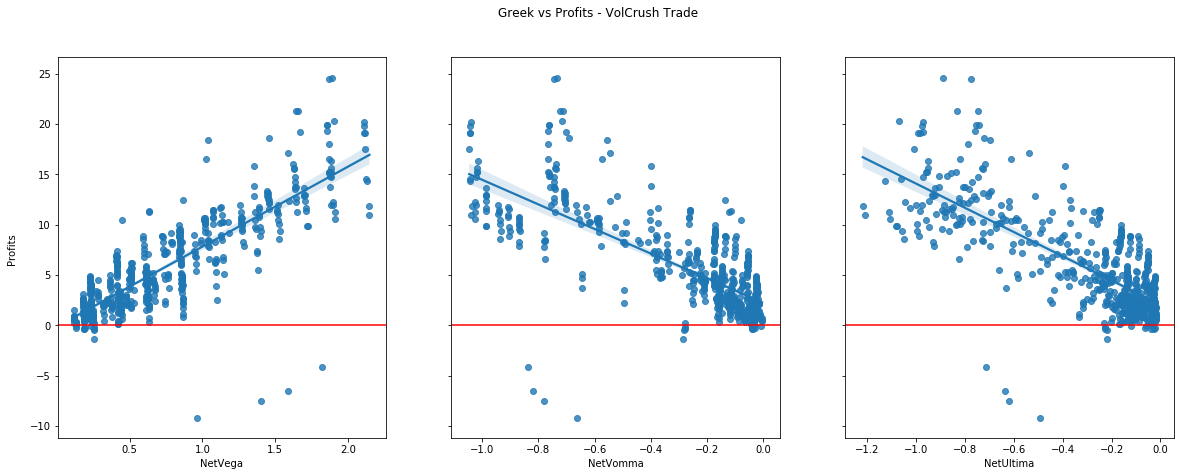

In [13]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 7))
sns.regplot(positions.NetVega, profits, ax=ax[0])
sns.regplot(positions.NetVomma, profits, ax=ax[1])
sns.regplot(positions.NetUltima, profits, ax=ax[2])
f.text(0.09, 0.5, 'Profits', va='center', rotation="vertical")
ax[0].axhline(y=0, color='red')
ax[1].axhline(y=0, color='red')
ax[2].axhline(y=0, color='red')
f.suptitle("Greek vs Profits - VolCrush Trade")
plt.savefig(f"plots/greeks_vs_profit{TRADES}.png")

### Distribution of Greeks

Text(0.5, 1.02, 'VolCrush Trade Greek Distributions & Correlations')

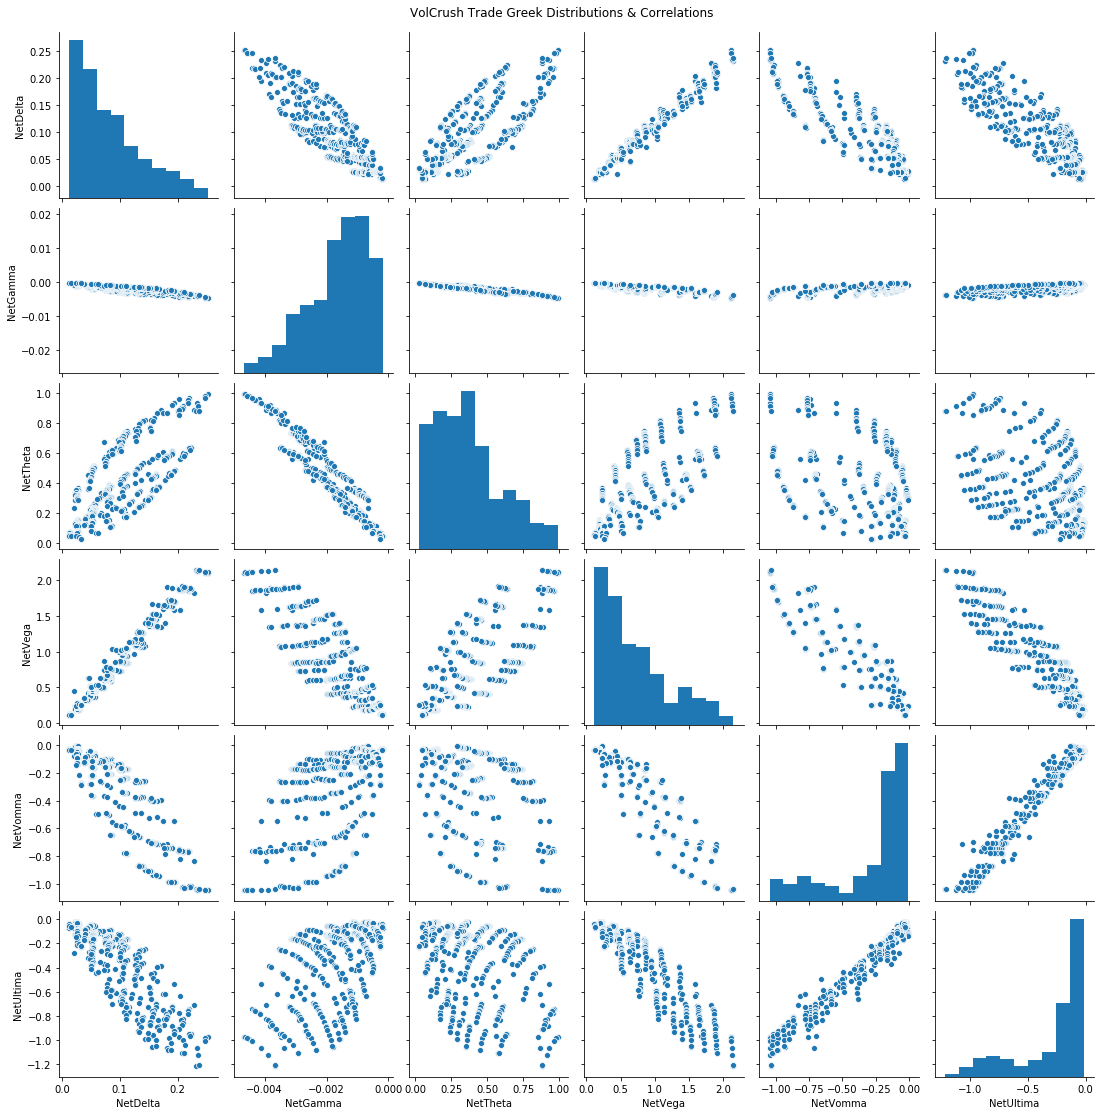

In [14]:
g = sns.pairplot(positions.iloc[:, :6])
g.fig.suptitle("VolCrush Trade Greek Distributions & Correlations", y = 1.02)

In [15]:
g.savefig(f"plots/volcrush_trade_pairplot_{TRADES}.png")

### Plot Corresponding

In [16]:
idc = np.argwhere(np.array(profits) > 10).reshape(-1, )
idc = np.argsort(profits).reshape(-1, )[::-1]
profits = np.array(profits)[idc]

In [17]:
ordered_positions = position_legs.iloc[idc].reset_index(drop=True)

In [18]:
ordered_positions['Profit'] = profits

In [19]:
ordered_positions.head(100)

,LongCall,ShortCall,LongPut,ShortPut,Profit
0,TSLA 2020-08-21 C260,TSLA 2022-01-21 C260,TSLA 2020-08-21 P338,TSLA 2022-01-21 P338,24.625
1,TSLA 2020-08-21 C280,TSLA 2022-01-21 C280,TSLA 2020-08-21 P316,TSLA 2022-01-21 P316,24.515
2,TSLA 2020-09-18 C260,TSLA 2022-01-21 C260,TSLA 2020-09-18 P338,TSLA 2022-01-21 P338,21.335
3,TSLA 2020-09-18 C280,TSLA 2022-01-21 C280,TSLA 2020-09-18 P316,TSLA 2022-01-21 P316,21.320
4,TSLA 2020-08-21 C242,TSLA 2022-01-21 C242,TSLA 2020-08-21 P356,TSLA 2022-01-21 P356,20.345
...,...,...,...,...,...
95,TSLA 2021-01-15 C340,TSLA 2022-01-21 C340,TSLA 2021-01-15 P256,TSLA 2022-01-21 P256,10.625
96,TSLA 2020-09-18 C360,TSLA 2022-06-17 C360,TSLA 2020-09-18 P240,TSLA 2022-06-17 P240,10.605
97,TSLA 2020-11-20 C350,TSLA 2022-01-21 C350,TSLA 2020-11-20 P248,TSLA 2022-01-21 P248,10.530
98,TSLA 2020-10-16 C236,TSLA 2021-01-15 C236,TSLA 2020-10-16 P362,TSLA 2021-01-15 P362,10.495


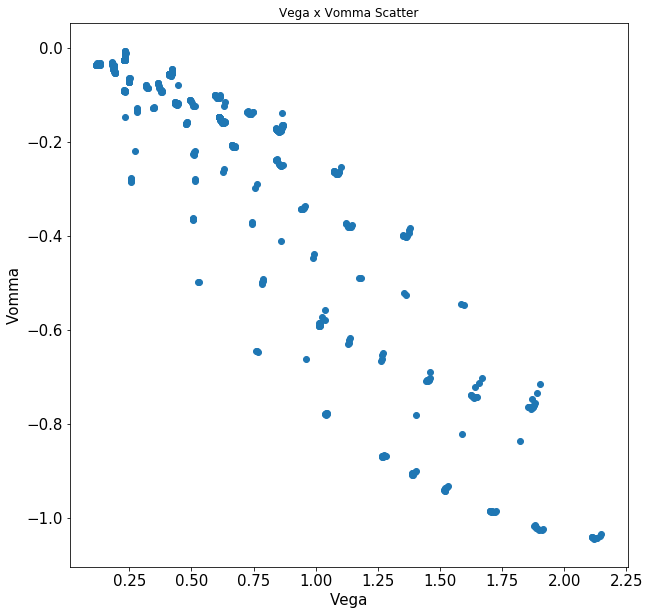

In [53]:
plt.figure(figsize=(10, 10))
plt.scatter(positions.NetVega, positions.NetVomma)
plt.xlabel("Vega", size=15)
plt.ylabel("Vomma", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Vega x Vomma Scatter")
plt.savefig("plots/vega_vomma_scatter.png")
plt.show()

In [20]:
ordered_positions.columns = ['ShortCall', 'LongCall', 'ShortPut', 'LongPut', 'Profits']

In [21]:
ordered_positions.to_csv("data/tsla_volcrush_trades.csv", index=False)

In [22]:
aiv = positions.AvgIV.values.copy()
aiv[aiv < 90] = 12.5
aiv[(aiv >= 90) & (aiv < 100)] = 25
aiv[(aiv >= 100) & (aiv < 110)] = 50
aiv[(aiv >= 110)] = 75

AttributeError: 'DataFrame' object has no attribute 'AvgIV'

In [ ]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 7))
sns.scatterplot(positions.NetVega, profits, hue=positions.AvgIV.values.copy(), palette='viridis', ax=ax[0])
sns.scatterplot(positions.NetVomma, profits, hue=positions.AvgIV.values.copy(), palette='viridis', ax=ax[1])
sns.scatterplot(positions.NetUltima, profits, hue=positions.AvgIV.values.copy(), palette='viridis',  ax=ax[2])
f.text(0.09, 0.5, 'Profits', va='center', rotation="vertical")
ax[0].axhline(y=0, color='red')
ax[1].axhline(y=0, color='red')
ax[2].axhline(y=0, color='red')
f.suptitle("Greek vs Profits (Coloured by Position IV) - VolCrush Trade")
plt.savefig(f"plots/greeks_vs_profit_colored{TRADES}.png")

### End of Data

In [ ]:
df = pd.read_csv("data/filtered_tsla_options_w_greeks.csv")
df = df[df.date_current == '2020-07-23']

In [ ]:
df.head()

### Check Pairs

In [ ]:
positions_end = []
for pair in expiration_pairs:
        
    e1, e2, day1, day2 = pair
    d1 = df[df.expiration_date == e1]
    d2 = df[df.expiration_date == e2]
    
    d1c = d1[d1.option_type == 'C'][cols]
    d1p = d1[d1.option_type == 'P'][cols]
    
    d2c = d2[d2.option_type == 'C'][cols]
    d2p = d2[d2.option_type == 'P'][cols]
    
    calls = d1c.merge(d2c, on='strike_price', how='inner')
    puts = d1p.merge(d2p, on='strike_price', how='inner')
        
    puts['moneyness'] = ((1 - puts.strike_price / 299.41) * 100).round(0)
    calls['moneyness'] = ((calls.strike_price / 299.41 - 1) * 100).round(0)
    
    puts['abs_moneyness'] = puts.moneyness.abs().reset_index(drop=True)
    calls['abs_moneyness'] = calls.moneyness.abs().reset_index(drop=True)
    
    puts = puts.drop_duplicates(subset=['moneyness'], keep='first')
    puts = puts.sort_values('moneyness')
    
    calls = calls.drop_duplicates(subset=['moneyness'], keep='first')
    calls = calls.sort_values('moneyness')
    
    puts = puts.drop(['abs_moneyness'], axis=1)
    calls = calls.drop(['abs_moneyness'], axis=1)
        
    puts.columns = ['strike_price'] + ['put_'+col for col in ocols] + ['moneyness']
    calls.columns = ['strike_price'] + ['call_'+col for col in ocols] + ['moneyness']
    
    legs = calls.merge(puts, on=['moneyness'], how='inner')
    
    pos = pd.DataFrame()
    
    for greek in ['Delta', 'Gamma', 'Theta', 'Vega', 'Vomma', 'Ultima']:
        
        value = TRADES[0] * legs['call_'+greek.lower()+'_x'].values
        value += TRADES[1] * legs['call_'+greek.lower()+'_y'].values
        value += TRADES[2] * legs['put_'+greek.lower()+'_x'].values
        value += TRADES[3] * legs['put_'+greek.lower()+'_y'].values
        
        pos['Net'+greek] = value
    
    pos['AvgIV'] = (legs.call_iv_x + legs.call_iv_y + legs.put_iv_x + legs.put_iv_y) / 4
    
    pos['CallStrike'] = legs.strike_price_x
    pos['PutStrike'] = legs.strike_price_y
    
    pos['Date1'] = e1
    pos['Date2'] = e2
    
    pos['Days1'] = day1
    pos['Days2'] = day2
    
    positions_end.append(pos)
        
positions_end = pd.concat(positions_end)

In [45]:
start_end_greeks = positions.merge(positions_end, on=["CallStrike", "PutStrike", "Date1", "Date2"])

Text(0.5, 1.0, 'Ultima Regression Slope: 0.8978384281155228')

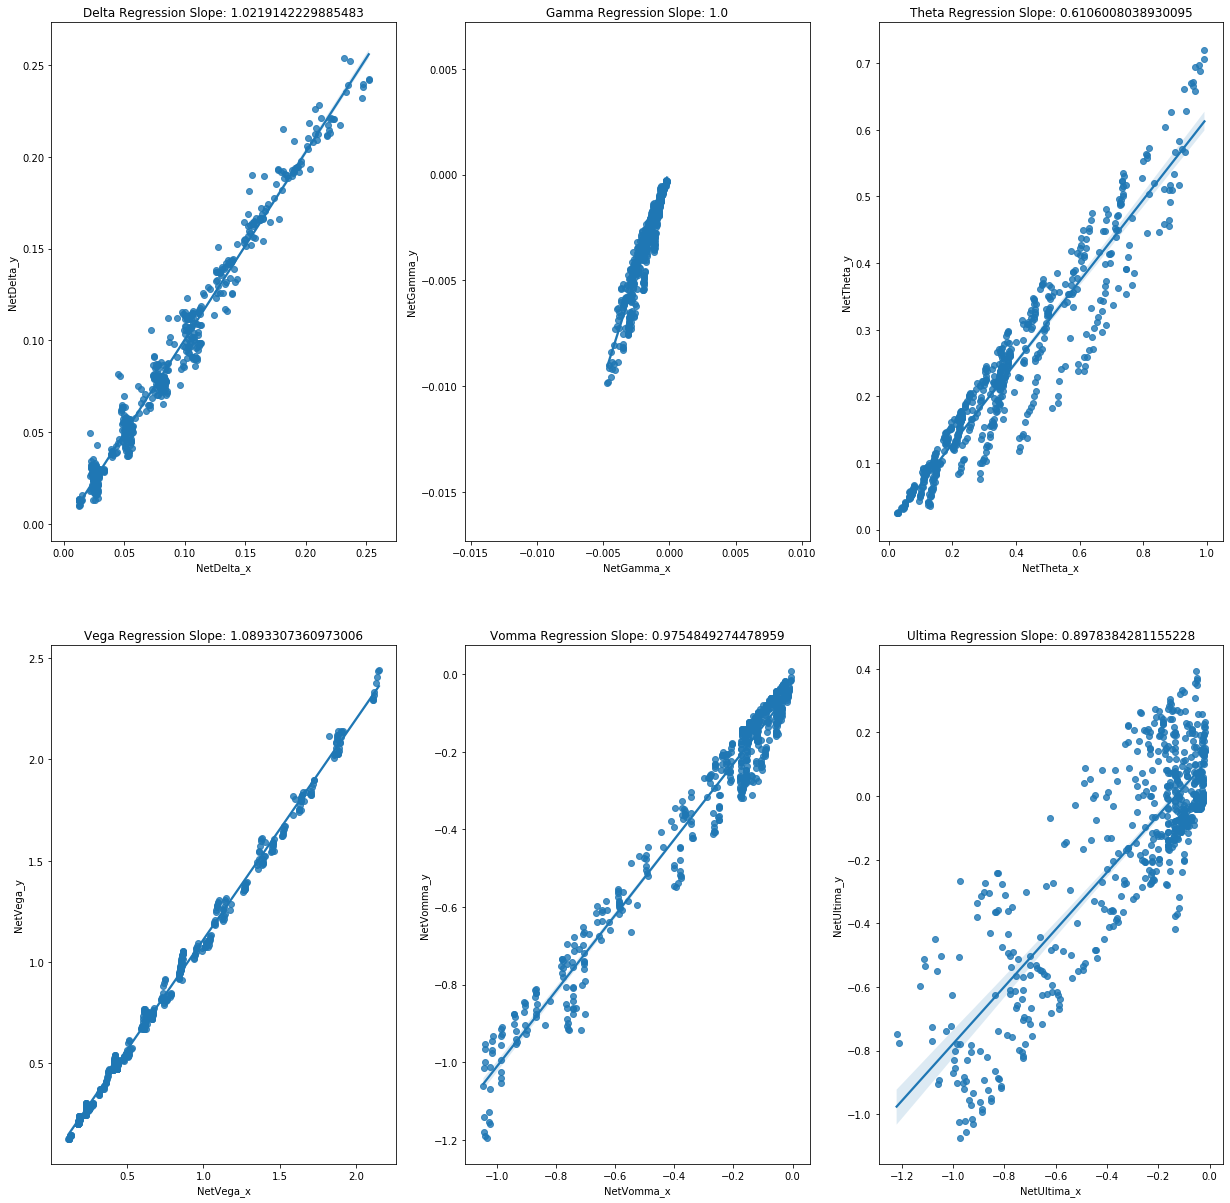

In [46]:
f, ax = plt.subplots(2, 3, figsize=(21, 21))
sns.regplot(x='NetDelta_x', y='NetDelta_y', data=start_end_greeks, ax=ax[0][0], fit_reg=True)
lr = LinearRegression()
lr = lr.fit(start_end_greeks.NetDelta_x.values.reshape(-1, 1), start_end_greeks.NetDelta_y.values.reshape(-1, 1))
ax[0][0].set_title(f"Delta Regression Slope: {lr.coef_[0][0]}")

sns.regplot(x='NetGamma_x', y='NetGamma_y', data=start_end_greeks, ax=ax[0][1])
lr = LinearRegression()
lr = lr.fit(start_end_greeks.NetGamma_x.values.reshape(-1, 1), start_end_greeks.NetGamma_x.values.reshape(-1, 1))
ax[0][1].set_title(f"Gamma Regression Slope: {lr.coef_[0][0]}")

sns.regplot(x='NetTheta_x', y='NetTheta_y', data=start_end_greeks, ax=ax[0][2])
lr = LinearRegression()
lr = lr.fit(start_end_greeks.NetTheta_x.values.reshape(-1, 1), start_end_greeks.NetTheta_y.values.reshape(-1, 1))
ax[0][2].set_title(f"Theta Regression Slope: {lr.coef_[0][0]}")

sns.regplot(x='NetVega_x', y='NetVega_y', data=start_end_greeks, ax=ax[1][0])
lr = LinearRegression()
lr = lr.fit(start_end_greeks.NetVega_x.values.reshape(-1, 1), start_end_greeks.NetVega_y.values.reshape(-1, 1))
ax[1][0].set_title(f"Vega Regression Slope: {lr.coef_[0][0]}")

sns.regplot(x='NetVomma_x', y='NetVomma_y', data=start_end_greeks, ax=ax[1][1])
lr = LinearRegression()
lr = lr.fit(start_end_greeks.NetVomma_x.values.reshape(-1, 1), start_end_greeks.NetVomma_y.values.reshape(-1, 1))
ax[1][1].set_title(f"Vomma Regression Slope: {lr.coef_[0][0]}")

sns.regplot(x='NetUltima_x', y='NetUltima_y', data=start_end_greeks, ax=ax[1][2])
lr = LinearRegression()
lr = lr.fit(start_end_greeks.NetUltima_x.values.reshape(-1, 1), start_end_greeks.NetUltima_y.values.reshape(-1, 1))
ax[1][2].set_title(f"Ultima Regression Slope: {lr.coef_[0][0]}")

In [47]:
from sklearn.linear_model import LinearRegression